Felipe Bartelt de Assis Pessoa - 2016026841


# Bases reais com ELMs
## Breast Cancer
### ELM

A primeira base real utilizada foi a *Breast Cancer*, que é carregada por meio do seguinte trecho de código:

In [45]:
import numpy as np
import plotly.graph_objects as go
from sklearn.datasets import load_breast_cancer

# Load dataset
breast_cancer = load_breast_cancer()
X_samples = breast_cancer['data']
y_sample = np.reshape(breast_cancer['target'], (-1,1))


Definiu-se as funções para treinamento de ELM `train_elm`, normalização de dados de entrada `normalize_features`, remoção de dados de entrada `delete_features` e avaliação de acurácia `eval_accuracy`. Essas funções são réplicas das já utilizadas nos exercícios anteriores, portanto não se vê como necessário explicação das mesmas. Ainda, foi feita uma modificação sobre a função `eval_accuracy`, uma vez que o treinamento de ELM se baseia na função de ativação $\tanh(\cdot)$, cuja imagem $\in [-1,1]$, tem-se $(y_{test}-\widehat{y})^2 = 4\ \forall y_{test}\neq \widehat{y}$, portanto foi adicionado um novo argumento `nn_type` que indica se a rede é ELM (`nn_type = 1`) ou perceptron (`nn_type = 0`), assim, o erro quadrático será dividido por $4$ caso a rede seja ELM.

A divisão supracitada não ocorre justamente para redes ELM, mas sim com base na função de ativação, porém, uma vez que se implementou a ELM com função de ativação $\tanh(\cdot)$ e a rede perceptron com função de ativação logística, preferiu-se manter a notação baseada no tipo de rede visando tornar os argumentos do código mais uniformes.

In [46]:
def train_elm(x_train, y_train, hidden_dim):
    # Returns a weight vector based on sigmoidal mapping given by tanh
    m = np.shape(x_train)[1]
    Z = np.random.default_rng().uniform(-0.5, 0.5, (m, hidden_dim))
    H = np.tanh(x_train @ Z)
    W = np.linalg.pinv(H) @ y_train
    return W, Z

def normalize_features(X, mean, std):
    Xtemp = np.copy(X)
    Xtemp = Xtemp - mean
    Xtemp = Xtemp / std
    return Xtemp

def delete_features(X, feat_idx):
    # Returns matrix X with features indexes in feat_idx ignored
    Xtemp = np.copy(X)
    Xtemp = np.delete(Xtemp, feat_idx,1)
    return Xtemp

def eval_accuracy(y_hat, y, nn_type = 0):
    # Divides quadratic error by 4 if activation function is tanh
    N = np.shape(y)[0] * (4 ** nn_type)
    return (1 - ((y-y_hat).T @ (y-y_hat)) / N).ravel()


Definiu-se a função de treinamento do perceptron `train_perceptron` com base no método gradiente descendente, diferentemente do algoritmo implementado na Lista 3. Essa função tem como parâmetros os dados de entrada e saída `x_train, y_train`; o vetor de pesos inicial `init_w`, que, caso não fornecido, é iniciado como uma distribuição uniforme entre $[-\epsilon,\epsilon]$, onde $\epsilon = \frac{\sqrt{6}}{\sqrt{L_{in}+L_{out}}}$, sendo $L_{in}$ o número de neurônios na camada anterior e $L_{out}$ o número de neurônios da camada posterior; o passo do gradiente descendente `eta`, default $=0.1$; a tolerância `tol`, default = $10^{-5}$; e o número máximo de iterações para convergência `max_iter`, por default = $500$. Essa função retorna o vetor de pesos `w` com os valores ótimos obtidos.

Para o funcionamento da função `train_perceptron`, definiu-se como função de custo, visando a convexidade, $J = -\frac{1}{N}\left(y^T\ln{\left(h(xw)\right)}+(1-y^T)\ln{\left(1-h(xw)\right)}\right)$, cujo gradiente é $\frac{\partial J}{\partial w} = \frac{1}{N}\left(x^T\left(h\left(xw\right)-y\right)\right)$, sendo $x$ os dados de entrada, $y$ os dados de saída, $N$ o número de amostras e $h(\cdot)$ a função sigmoidal logística: $h(u) = \frac{1}{1+e^{-u}}$. 

Dessa forma, a função `cost_function` implementa justamente a função citada, tendo como parâmetros o vetor de pesos `weight_vector`, os dados de entrada e saída `input_samples, output_samples` e o parâmetro de regularização `reg_par`, cujo default $=0$. A função `sigmoid` implementa a função sigmoidal logística. A função `predict_label` retorna a classe aproximada, sendo $1\text{ se } h(z)\ge0.5,\quad 0 \text{ se } h(z)<0.5$.

In [47]:
def sigmoid(z):
    # Logistic function
    return 1/(1+np.exp(-z))

def cost_function(weigth_vector, input_samples, output_samples, reg_par = 0):
    m = np.shape(input_samples)[0]
    u = sigmoid(input_samples @ weigth_vector)
    J = -1/m*(output_samples.T @ np.log(u) 
              + (1 - output_samples).T @ (np.log(1 - u))) + sum(reg_par/(2*m)*(weigth_vector[1::]**2))
    return float(J.ravel())

def predict_label(y):
    # Return the label corresponding to sigmoid value
    return 1*(y >= 0.5)

def train_perceptron(x_train, y_train, init_w=None, eta=0.1, tol=1e-5, max_iter = 500):
    # Minimize defined costfunction based on gradient descendent
    N = np.shape(x_train)[0]

    if init_w is None:
        Lin, Lout = np.shape(x_train)[1], np.shape(y_train)[1]
        epsilon = np.sqrt(6)/np.sqrt(Lin+Lout)
        init_w = np.random.default_rng().uniform(-epsilon,epsilon,(Lin,Lout))
    
    w = init_w
    itern, err = 0, tol+1
    
    while (itern < max_iter) and (abs(err) > tol):
        y_hat = sigmoid(x_train @ w)
        err = cost_function(w, x_train, y_train)
        w = w - eta/N*(x_train.T @ (y_hat - y_train))
        itern += 1
    
    return w



Em seguida, altera-se as saídas nulas para $-1$, já que a rede ELM se baseia na função de ativação $\tanh(\cdot)$. Normaliza-se os dados de entrada e despreza-se os dados de entrada $2,3,9,11,12,13,14,18,19,22 \text{ e } 23$, uma vez que, como já analisado anteriormente, esses dados não têm grande influência quanto à classe prevista ou representam combinação linear de outros dados.

In [48]:
N = np.shape(X_samples)[0]
y_sample[y_sample==0] = -1

# Normalize features
X_mean = np.mean(X_samples, axis = 0)
X_std = np.std(X_samples, axis = 0)
X_samplen = normalize_features(X_samples, X_mean, X_std)

# Remove useless features and append x0
ignored_idx = [2,3,9,11,12,13,14,18,19,22,23]
X_sample = delete_features(X_samplen, ignored_idx)
X_sample = np.append(np.ones((N,1)), X_sample, 1)



Uma vez que serão necessárias diversas iterações dos algoritmos, definiu-se a função `iterate_neuralnetwork`, que tem como argumentos os dados de entrada e saída `X_sample, y_sample`; o tipo de rede neural `nn_type` ($0=$ perceptron, $1=$ ELM); a lista de hiperparâmetros `hyper_params` para que se teste a rede ELM para diversos números de neurônios, default = $[1]$ e se a rede escolhida é do tipo *perceptron*, esse parâmetro é desconsiderado; o número de iterações `iter_num` desejadas para execução, de forma a se obter média e desvio padrão das acurácias obtidas nas iterações; e `eta`, o passo do algoritmo perceptron.

O retorno dessa função são duas listas de tuplas, a primeira lista `acc_train_list` carrega as médias e desvio padrão, como tuplas, das acurácias obtidas para cada hiperparâmetro nos dados de treinamento, a outra lista `acc_train_list` traz as mesmas informações, porém para os dados de teste.

In [49]:
def iterate_neuralnetwork(X_sample, y_sample, nn_type, hyper_params=[1], iter_num = 10, eta=0.1):
   
    if not nn_type:
        hyper_params = [1]
    
    acc_test_list, acc_train_list = [], []
    N = np.shape(X_sample)[0]
    
    for p in hyper_params:
        acc_test, acc_train = [], []

        for _ in range(iter_num):
            # Get indexes corresponding to each class
            idx1 = [idx for idx, val in enumerate(y_sample.flatten()) if val==1]
            idx0 = sorted(list(set(range(0,N)) - set(idx1)))
            N0,N1 = len(idx0), len(idx1)
            N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
            # Randomize indexes
            np.random.default_rng().shuffle(idx0)
            np.random.default_rng().shuffle(idx1)

            # Select samples for training and testing
            x_train = X_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
            x_test = X_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]
            y_train = y_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
            y_test = y_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]
            
            if nn_type:
                w, Z = train_elm(x_train, y_train, p)
                y_hat_train = np.sign(np.tanh(x_train @ Z) @ w)
                y_hat_test = np.sign(np.tanh(x_test @ Z) @ w)
            else:
                w = train_perceptron(x_train, y_train, eta=eta)
                y_hat_train = predict_label(sigmoid(x_train @ w))
                y_hat_test = predict_label(sigmoid(x_test @ w))

            acc_train.append(eval_accuracy(y_hat_train, y_train, nn_type))
            acc_test.append(eval_accuracy(y_hat_test, y_test, nn_type))
            
        acc_train_list.append((np.mean(acc_train), np.std(acc_train)))
        acc_test_list.append((np.mean(acc_test), np.std(acc_test)))

    return acc_train_list, acc_test_list


Assim, treinou-se uma rede ELM para os hiperparâmetros $[5, 10, 30, 50, 100, 300]$, com 100 iterações para cada número de neurônios. As médias e desvios padrão das acurácias obtidas nessas iterações, para treinamento e teste, podem ser vistas a seguir:

In [50]:
hyper_params = [5, 10, 30, 50, 100, 300]
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_sample, 1, hyper_params, 100)

print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_train_list):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_test_list):
    print('\t',i,'\t',j[0],'±',j[1])

hiperparametro: 		training accuracy:
	 5 	 0.8823869346733669 ± 0.05214363322493764
	 10 	 0.9384924623115577 ± 0.017281903111263295
	 30 	 0.969497487437186 ± 0.007897764715911157
	 50 	 0.9765326633165831 ± 0.006000976326885188
	 100 	 0.9856281407035177 ± 0.003861180444683122
	 300 	 0.9999748743718593 ± 0.0002499968434941212

hiperparametro: 		test accuracy:
	 5 	 0.8762573099415204 ± 0.05624819077225214
	 10 	 0.9339181286549706 ± 0.024386736212857363
	 30 	 0.9597076023391813 ± 0.014056878794934904
	 50 	 0.960701754385965 ± 0.01637593976438562
	 100 	 0.9621637426900586 ± 0.012744111039933169
	 300 	 0.8709941520467833 ± 0.02590082180204993


Conforme se aumenta o número de neurônios, a acurácia para os dados de treinamento se torna cada vez melhor, porém, para os dados de teste, isso não é verdade. Apesar da acurácia nos testes melhorar até $100$ neurônios, nota-se *overfitting* para o próximo hiperparâmetro, $300$, para o qual se obteve uma acurácia de aproximadamente $100\%$ nos dados de treinamento, enquanto para os dados de teste essa acurácia cai para $87\%$ aproximadamente, o que em relação ao hiperparâmetro anterior, equivale à uma queda de $9\%$ de precisão.

Por meio dos resultados acima, pode-se estimar que a acurácia máxima é obtida pelo hiperparâmetro $100$, uma vez que a acurácia, nos dados de teste, para esse número foi a melhor dentre os avaliados: $(96.2\pm1.3\%)$. Porém, o verdadeiro máximo repousa entre 50 e 300, valores que englobam o máximo obtido anteriormente, assim, como forma de se obter uma melhor estimativa para o número de neurônios que fornece a máxima acurácia, itera-se novamente a rede ELM para todos os hiperparâmetro entre 50 e 300, tomando-se um número de execuções igual a 10 e se obtém o número de neurônios correspondente à máxima acurácia obtida:

In [51]:
hyper_params = np.arange(50,300)
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_sample, 1, hyper_params)

idx = np.argmax(acc_test_list)//2
print(hyper_params[idx], acc_test_list[idx])

52 (0.9701754385964911, 0.009591356413366494)



Por meio dessas novas iterações, obteve-se a máxima acurácia nos dados de teste para o hiperparâmetro $52$, equivalente a $(97\pm0.1)\%$. Sendo assim, permite-se dizer que o número aproximado de neurônios para maximização da acurácia é $52$, porém seria necessário a utilização de um conjunto para validação cruzada para se determinar com maior certeza o hiperparâmetro ótimo para essa base de dados.

### Perceptron
De forma a se avaliar a eficácia da rede ELM para dados reais, treinou-se uma rede do tipo perceptron para a mesma base de dados, já normalizada e com dados desprezados, da mesma forma que anteriormente. Iterou-se, também, 100 vezes o treinamento, tomando-se ao final a média e desvio padrão das acurácias nos dados de treinamento e teste.

Uma vez que o perceptron implementado se baseia na função de ativação logística, cuja imagem é $(0,1)$, necessitou-se reverter a alteração das classes de saída, assim as saídas iguais a $-1$, tornaram-se novamente $0$.

In [8]:
y_samplep = np.copy(y_sample)
y_samplep[y_samplep == -1] = 0
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_samplep, 0, iter_num=100, eta=0.1)

print('training accuracy:')
print(acc_train_list[0][0], '±', acc_train_list[0][1])
print('\ntest accuracy:')
print(acc_test_list[0][0],'±',acc_test_list[0][1])

training accuracy:
0.979070351758794 ± 0.00474142639023691

test accuracy:
0.9717543859649124 ± 0.01125043459826513



Percebe-se então, que o desempenho do perceptron foi superior ao desempenho da ELM. Mesmo a melhor acurácia encontrada para ELM, $(97\pm0.1)\%$, é inferior à obtida pelo perceptron: $(97.2\pm 1.1)\%$. Ambas as redes obtiveram acurácias similares, porém ao se considerar os resultados com mais iterações para a ELM, obteve-se uma acurácia $1\%$ menor que a do perceptron, sendo os desvios padrão bastante próximos. Feita essas observações, pode-se concluir que, para essa base de dados, os dois tipos de rede estudados são eficazes, sendo o perceptron levemente superior.

## Statlog (Heart)
### ELM

A base de dados foi baixada do site fornecido. Armazenou-se os dados e plotou-se a matriz de correlação de forma a se avaliar quais variáveis são de fato importantes:

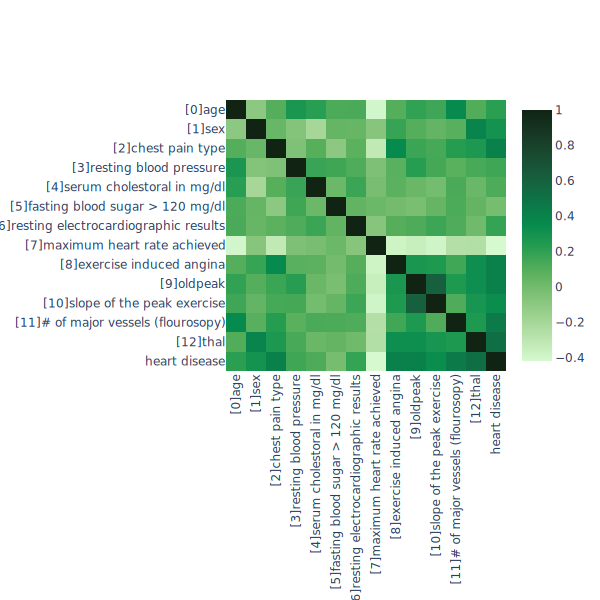

In [52]:
import pandas as pd
import plotly.graph_objects as go

data = np.loadtxt( 'heart.dat' )
X_samples = np.copy(data[:, 0:-1])
y_sample = np.reshape(np.copy(data[:, -1]), (-1,1))
feat_names = ['[0]age', '[1]sex','[2]chest pain type','[3]resting blood pressure','[4]serum cholestoral in mg/dl','[5]fasting blood sugar > 120 mg/dl','[6]resting electrocardiographic results','[7]maximum heart rate achieved','[8]exercise induced angina','[9]oldpeak','[10]slope of the peak exercise','[11]# of major vessels (flourosopy)','[12]thal', 'heart disease']

df = pd.DataFrame(data, columns = feat_names)
corr = df.corr()
fig = go.Figure(go.Heatmap(z=corr.values,x=corr.index.values, y=corr.columns.values, colorscale='algae'))
fig.update_layout(yaxis_autorange='reversed', width = 600, height = 600, xaxis= dict(tickangle = -90))
fig.show(renderer = 'svg', width = 600, height =600)


Analisando-se a matriz de correlação, escolheu-se ignorar os dados $4\text{ e } 5$, cujas correlações com a classe de saída são menores, em módulo, que $0.1$.

Necessita-se de alterar as classes de valor $2$ para valores iguais a $-1$, além disso, os dados claramente necessitam de normalização, uma vez que há diversas unidades e escalas diferentes.

In [53]:
N = np.shape(X_samples)[0]
y_sample[y_sample==2] = -1

X_mean = np.mean(X_samples, axis = 0)
X_std = np.std(X_samples, axis = 0)
X_samplen = normalize_features(X_samples, X_mean, X_std)

# Remove useless features and append x0
ignored_idx = [4,5]
X_sample = delete_features(X_samplen, ignored_idx)
X_sample = np.append(np.ones((N,1)), X_samplen, 1)


Com os dados melhorados, pode-se tomar o mesmo procedimento feito para o *Breast Cancer*, utilizando-se o mesmo número de iterações:

In [54]:
hyper_params = [5, 10, 30, 50, 100, 300]
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_sample, 1, hyper_params, 100)

print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_train_list):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_test_list):
    print('\t',i,'\t',j[0],'±',j[1])

hiperparametro: 		training accuracy:
	 5 	 0.7556613756613757 ± 0.05340184144527309
	 10 	 0.8218518518518519 ± 0.026969131635936953
	 30 	 0.8772486772486772 ± 0.0158023116646223
	 50 	 0.9040211640211641 ± 0.019555544103159794
	 100 	 0.9668783068783068 ± 0.011461348256172843
	 300 	 1.0 ± 0.0

hiperparametro: 		test accuracy:
	 5 	 0.7406172839506173 ± 0.06772131044082046
	 10 	 0.7909876543209877 ± 0.0459370423291322
	 30 	 0.814567901234568 ± 0.03801106056793419
	 50 	 0.7954320987654322 ± 0.041252121642518506
	 100 	 0.7396296296296296 ± 0.0456321080509102
	 300 	 0.6999999999999998 ± 0.04880838864387851



Para essa base de dados, o desempenho da ELM foi pior. Novamente, apesar da acurácia de treino só melhorar, o comportamento da acurácia de teste não segue esse padrão, ao alcançar um certo máximo, essa acurácia começa a decair, indicando *overfitting*. Percebe-se ainda que para 300 neurônios os dados de entrada são perfeitamente interpolados, obtendo-se o máximo de *overfitting* possível. Ainda é interessante notar que mesmo havendo perfeita interpolação dos dados com o hiperparâmetro $300$, a acurácia de testes ainda é $70\%$.

Dentre os valores analisados, o número de neurônios que permite a maximização da acurácia é $30$, sendo aproximada de $(81.5\pm3.8)\%$.

Uma vez que o hiperparâmetro ótimo está entre $10$ e $50$, iterou-se novamente a ELM para todos esses valores, $10$ vezes para cada hiperparâmetro, de forma a se obter a máxima acurácia:

In [55]:
hyper_params = np.arange(10,50)
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_sample, 1, hyper_params)

idx = np.argmax(acc_test_list)//2
print(hyper_params[idx], acc_test_list[idx])

12 (0.8358024691358026, 0.0292412821785852)



Com as novas iterações, obtém-se máxima acurácia para $12$ neurônios, de aproximadamente $(83.6\pm2.9)\%$. Dessa forma o número ótimo é aproximadamente $12$ neurônios.

### Perceptron

Da mesma forma que anteriormente, com os mesmos parâmetros, treinou-se a rede perceptron. Novamente, alterou-se as saídas $-1$ para valores $0$.

In [18]:
y_samplep = np.copy(y_sample)
y_samplep[y_samplep == -1] = 0
acc_train_list, acc_test_list = iterate_neuralnetwork(X_sample, y_samplep, 0, iter_num=100, eta=0.1)

print('training accuracy:')
print(acc_train_list[0][0], '±', acc_train_list[0][1])
print('\ntest accuracy:')
print(acc_test_list[0][0],'±',acc_test_list[0][1])

training accuracy:
0.8598412698412697 ± 0.01577562716225494

test accuracy:
0.8462962962962962 ± 0.036887558440317686


Percebe-se que novamente o perceptron teve melhor desempenho que a ELM, obtendo $(84.6\pm3.7\%)$ de acurácia. 

Supõe-se que o fato do perceptron ter apresentado um ótimo desempenho para ambos os conjuntos de dados se deve ao redimensionamento da base, desprezando-se alguns dados, somado ao uso da função de custo escolhida, que pode ter fornecido um ajuste melhor devido à sua convexidade.

A base de dados *Statlog* aparenta mais simples, porém, na prática essa observação não se concretizou. Não foi possível supor qualquer motivo para a piora de ambas as redes, uma vez que, mesmo utilizando todos os dados da base, o resultado da ELM e perceptron são os mesmos. Conjectura-se que pode ser possível melhorar a convergência de ambas as redes utilizando *data augmentation*, fazendo combinações entre os dados de entrada fornecidos.

Com esse estudo foi possível observar a robustez de uma rede do tipo perceptron, que mesmo sem múltiplas camadas, foi capaz de ter melhor desempenho que as ELMs. Notou-se também a eficácia das ELMs, que, mesmo projetando os dados de forma aleatória na camada intermediária, são capazes de classificar muito bem conjuntos reais de dados. 

Supõe-se ainda que a opção por uma rede perceptron ou ELM pode ser analisada pela complexidade da base de dados. Dependendo da separabilidade do conjunto, é possível que uma rede ELM necessite de um número exagerado de neurônios na camada intermediária, resultando em uma maior complexidade do que um simples perceptron. Da mesma forma, para bases mais simples, redes ELM são interessantes por não necessitarem de várias iterações, obtendo aproximações de forma direta, diferentemente do perceptron. Ou seja, a escolha do modelo de rede se dá não pelo modelo, mas sim pelos dados.